# Classical Statistical Inference: Uncertainty calculation

## Table of Content:

- II. What is statistical inference ? See [Frequentist_inference_01.ipynb](Frequentist_inference_01.ipynb)
    * II.1 Point estimate.  See [Frequentist_inference_01.ipynb](Frequentist_inference_01.ipynb)
    * II.2 Confidence interval. See [Frequentist_inference_02.ipynb](Frequentist_inference_02.ipynb)
    * II.3 Hypothesis testing See [Frequentist_inference_H_test.ipynb](Frequentist_inference_H_test.ipynb)
    * II.4 Uncertainty calculation using Monte-Carlo method:
        - II.4.1 [Variable transformation](#II.4.1-Variable-transformation)
            * II.4.1. [Log scale and the meaning of dex](#II.4.1.1-Base-10-logarithm-and-the-definition-of-the-"dex")
        - II.4.2 [Error propagation formula](#II.4.2-Error-propagation-formula:)
        - II.4.3 [Monte-Carlo-Error-estimate](#II.4.3-Monte-Carlo-Error-estimate:)
    * II.5 Bootstrap. See [Frequentist_inference_Bootstrap.ipynb](Frequentist_inference_Bootstrap.ipynb)
    
- X. [References and supplementary material](#X)

In [1]:
# Modules to be used in this notebook
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

## II.4 Monte-Carlo methods and uncertainty estimates

In scientific measurements, uncertainties are inevitable because no instrument is perfectly accurate. These experimental uncertainties depend on the characteristics and limitations of the measuring device and can be classified into two main categories: systematic and random uncertainties. Systematic uncertainties affect all measurements in the same way, often due to incorrect calibration or flaws in the model used to interpret raw data. They introduce a consistent bias that cannot be reduced by repeating the experiment. In contrast, random uncertainties vary unpredictably from one measurement to another. They arise from uncontrollable factors and follow a probability distribution. Unlike systematic errors, random uncertainties can be mitigated by performing multiple measurements and averaging the results, as their influence diminishes with repetition.

Beyond instrument-related errors, some uncertainties originate from the intrinsic randomness of the phenomena being studied. These are known as statistical fluctuations and occur independently of the measuring device. They are common in counting experiments, such as detecting particles emitted during radioactive decay or counting photons in optical systems. Because these processes are fundamentally stochastic, the number of observed events fluctuates around an expected value, introducing a random uncertainty into the measurement. Statistical fluctuations reflect the probabilistic nature of physical systems and cannot be eliminated, though their impact can be reduced by increasing the sample size or observation time.

Hence, random uncertainties are by essence random variables. Unfortunately, the random variable you are interested in is often a function of other random variables that are directly measured. A simple example in physics is the measurement of the speed of an object. You may not measure the speed directly but the distance and the time. Each time and distance that you measure has an associated uncertainty. Unfortunately, the quantity of interest is the velocity, i.e. distance / unit of time. How do you propagate the two uncertainties to derive the uncertainty on the speed? We will see below how to proceed thanks to the **error propagation formula**. This formula is an important tool for error propagation, but we will also introduce a numerical approach, the Monte-Carlo technique. This technique is particularly useful if you are in a situation where you cannot easily apply the error propagation formula (you need to calculate partial derivatives on random variable), or when you suspect that this formula is not valid (it is an approximate formula).

### II.4.1 Variable transformation

Let's start with the situation where you are interested in calculating uncertainties for a random variable that is a function of a single other random variable. We can take the following concrete example. Imagine that you have a sample of magnitude measurements (or relative magnitudes) of an object ( $m = -2.5 * \log(F)$, where $F$ is the flux). How do you estimate the mean and uncertainty on the mean? You may be tempted to use the standard formula, but you cannot because the magnitude is a *derived quantity*, the flux being what is effectively measured with some associated uncertainty.    

As you may know, any function of a random variable is a random variable. Let's consider the random variable $x$ and the function $y = \phi(x)$ of the latter. If we know the pdf $p(x)$ (where $x$ is a random variable), then ([see also](../03-Basic_statistics_and_proba_concepts/Descriptive_statistics_01.ipynb)) the probability distribution $p(y)$, where $y = \phi(x)$ (and so $x = \phi^{-1}(y)$), is:

$$
p(y) = P'(y) = p\left[ \phi^{-1} \left(y \right) \right] \left| \frac{{\rm d}\,\phi^{-1}(y) }{{\rm{d}} y} \right|
$$

where $P'(y)$ is the first derivative of the CDF.  

**Illustration:** Let's consider the case where $x$ is drawn from a uniform distribution, but we study $y = -2.5*\log(x)$. Then we have $x = \phi^{-1}(y) = 10^{-0.4*y} $. Since we have a uniform distribution for $x$, we have $p(x) = 1$ if $0 \leq x \leq 1$, and therefore $p(y) =  0.4\, \ln(10) \, 10^{-0.4\,y}$ with $0 \,< \,y \,<\,\infty $. 

Note that we take the absolute value of the first derivative. 

In [2]:
# create a uniform distribution
uniform_dist = scipy.stats.uniform(0.0001, 1)
x_sample = uniform_dist.rvs(1000)
# Calculate the pdf of x to overplot it
x = np.linspace(-0.5, 1.5, 1000)
Px = uniform_dist.pdf(x)

In [3]:
# transform the data
y_sample = -2.5*np.log10(x_sample)
# Calculate the pdf of y to overplot it
y = -2.5*np.log10(x)
Py = 0.4 * np.log(10) * Px * 10**(-0.4*y)

/Users/dsluse/miniconda3/envs/py3_lectures/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


Text(0, 0.5, '$p_y(y)$')

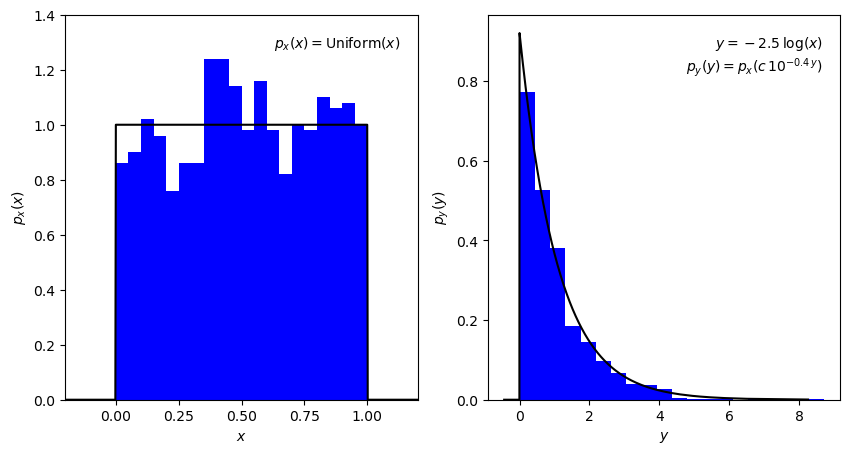

In [4]:
# Visualise the Uniform and transformed distribution 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.hist(x_sample, 20, histtype='stepfilled', fc='blue', density=True)
ax.plot(x, Px, '-k')
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(0, 1.4001)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.text(0.95, 0.95, r'$p_x(x) = {\rm Uniform}(x)$', va='top', ha='right', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p_x(x)$')


ax = fig.add_subplot(122)
ax.hist(y_sample, 20, histtype='stepfilled', fc='blue', density=True)
ax.plot(y, Py, '-k')
#ax.set_xlim(0.85, 2.9)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.text(0.95, 0.95, '$y=-2.5\,\log(x)$\n$p_y(y)=p_x(c\,10^{-0.4\,y})$', va='top', ha='right', transform=ax.transAxes)
ax.set_xlabel('$y$')
ax.set_ylabel('$p_y(y)$')

#### II.4.1.1 Base 10 logarithm and the definition of the "dex" 

Very frequently in astrophysics and geophysics, the quantity that we are interested in / that we are reporting is not the quantity itself, but its base 10 logarithm. This is for example the case of the mass of galaxies or galaxy halos ($\log(M_{\rm{Halo}}/M_{\odot})$), supermassive black holes ($\log(M_{BH}/M_{\odot})$), the metallicity ($\log[(Fe/H)/(Fe/H)_{\odot}]$), ... Naturally, the reported uncertainty is also the uncertainty on the logarithm (in base 10) of the quantity. The variable transformation formula allow you to easily convert the error if you have been working with the quantity itself and not its log. In that framework, you will often read / hear scientist stating that the uncertainty on the mass of this BH is e.g. **0.3 dex**. What does **dex** mean? **One dex** simply means one order of magnitude. More formally, a difference of $x$ dex is a change by a factor of $10^x$. For our black hole mass example, an uncertainty of 0.3 dex corresponds approximately to a factor $10^{0.3} \sim 2$ uncertainty. If the black hole mass is $10^9 M_{\odot} \pm 0.3$ dex whith 0.3 dex being the 1 standard error, it means that, if the uncertainties are gaussian, the 68.3\% confidence interval is $[10^{8.7}, 10^{9.3}] M_{\odot}$. Think of how you would have reported your uncertainties not using the "dex" 

It also means that if authors state that they assume a gaussian distribution centered on $\log(M/M_{\odot}) = \mu = 12$ with a standard deviation of 0.3 dex, they used a $\mathcal{N}(12,0.3)$. Beware however that if a quantity follows a normal distribution, it is unlikely that its $\log$ will follow a normal distribution (you can check it out analytically or numerically using python - see [II.4.3.](#II.4.3-Monte-Carlo-Error-estimate:) to find out how to proceed). 

More generally the term dex is also used as a replacement for "order of magnitude". [Don't be mistaken with the definition of magnitude by astronomers](https://ui.adsabs.harvard.edu/abs/1960Natur.187..879H/abstract). An order of magnitude means **a factor 10**, two orders of magnitudes a factor of $10^2 = 100$, ... But again, the principal motivation for using dex is the ability to use report fractional uncertainties easily. A fractional uncertainty of 25% corresponds to $\log(1.25) \sim 0.1 $ dex. 

As a historical footnote, the term “dex” was coined by the astronomer C. W. Allen during an IAU meeting in 1948, and a [short note advocating its use](https://ui.adsabs.harvard.edu/abs/1951Obs....71..157A/abstract) has been published in 1951 (The Observatory, Vol. 71, p. 157-157).  

#### Illustrative example

Let's consider a galaxy mass of $10^{10}\,M_\odot$ and a relative uncertainty of 20%. 
Calculate the dex uncertainty and compare the linear and dex uncertainty as follows: 
- Print the value log(M) and it's uncertainty in dex (i.e. log(M) ± dex_err)
- Show the linear interval: [M*(1-rel_err), M*(1+rel_err)] and the log interval: [logM - dex_err, logM + dex_err]

In [20]:
M = 1e10  # solar masses
rel_err = 0.2  # 20%
logM = np.log10(M)
dex_err_up = np.log10(1 + rel_err)  # upper bound
dex_err_low = np.log10(1 - rel_err)  # lower bound
print('log(M) = %.3f + %.3f %.3f'%(logM, dex_err_up, dex_err_low))
print('[M*(1-rel_err), M*(1+rel_err)] = [%.3e, %.3e]' %(M * (1-rel_err), M*(1+rel_err)))
print('[logM - dex_err, logM + dex_err] = [%.3f, %.3f]' %(logM+dex_err_low, logM+dex_err_up))

log(M) = 10.000 + 0.079 -0.097
[M*(1-rel_err), M*(1+rel_err)] = [8.000e+09, 1.200e+10]
[logM - dex_err, logM + dex_err] = [9.903, 10.079]


<ErrorbarContainer object of 3 artists>

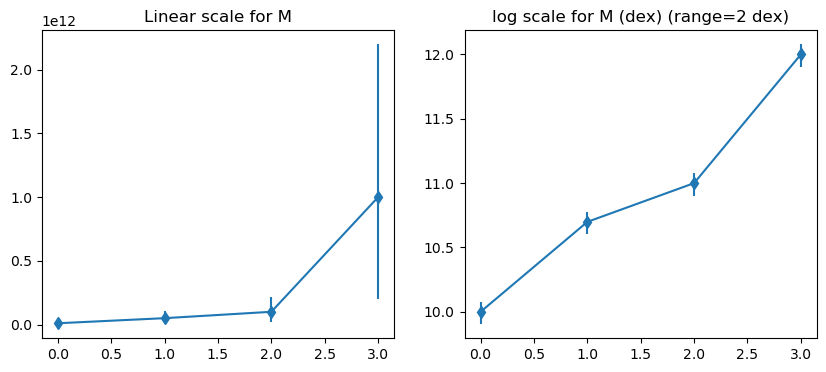

In [5]:
# Now, let's do it for 4 different masses that all have the same relative uncertainty 
# Let's plot the uncertainty in linear scale and in dex 
M = np.array([1.e10, 5.e10, 1.e11, 1.e12])
rel_err = 0.2  # 20%
# Linear uncertainty
M_err = np.array([M * (1-rel_err), M*(1+rel_err)])   # We have asymmetric uncertainties -> array(n, 2) needed

# dex and dex uncertainties
logM = np.log10(M)
dex_err_low = np.log10(np.ones_like(M) - rel_err) 
dex_err_up = np.log10(np.ones_like(M) + rel_err) 
dex_err = np.array([-dex_err_low, dex_err_up])

# Plot 
f, ax = plt.subplots(ncols=2, figsize=(10,4))
ax[0].set_title('Linear scale for M')
ax[1].set_title('log scale for M (dex) (range=2 dex)')
ax[0].errorbar(np.arange(len(M)), M, yerr=M_err, marker='d')
ax[1].errorbar(np.arange(len(M)), logM, yerr=dex_err, marker='d')

[1.e+10 5.e+10 1.e+11 1.e+12]
[[8.0e+09 4.0e+10 8.0e+10 8.0e+11]
 [1.2e+10 6.0e+10 1.2e+11 1.2e+12]]


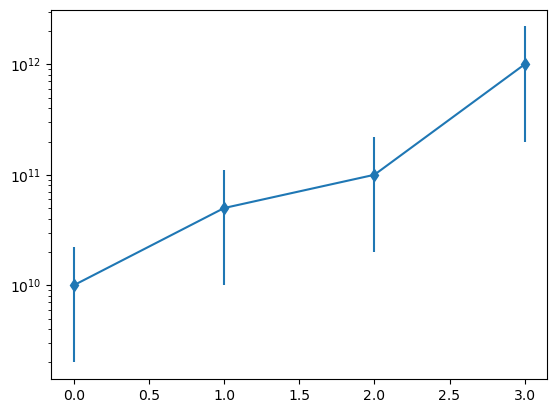

In [9]:
# BEWARE THAT if you use logscale in python, the uncertainties are not rescaled 
# The figure below is WRONG
plt.errorbar(np.arange(len(M)), M, yerr=M_err, marker='d')
plt.yscale('log')
print(M)
print(M_err)

The above figure WRONGLY displays the uncertainties in logspace. You need to calculate your uncertainties in dex!  

### II.4.2 Error propagation formula:


How do you proceed if you have a function of more than one random variable ? Then, you need to use the *error propagation formula* given below. This is a **very important** formula that you need to know. Knowing the demonstration is not compulsory, but understanding it is insightful and allows you to understand the assumptions entering into the formula.   

If we have a function $z = \phi(x,y)$, where $x $ and $y$ are random variable with sample values $x_i = {x_1, ..., x_n}$ and $y_i = {y_1, ..., y_n}$, then the error on $\sigma_z$ is given by the **Error propagation formula**:  

$$
\sigma_z^2 \, = \left( \frac{\partial \phi}{\partial x} \right)_\bar{x}^2  \sigma_x^2 \, + \left( \frac{\partial \phi}{\partial y} \right)_\bar{y}^2  \sigma_y^2  + 2  \left( \frac{\partial \phi}{\partial x} \right)_\bar{x} \left( \frac{\partial \phi}{\partial y} \right)_\bar{y} \sigma_{xy}
$$

*Demonstration:* 

We can define $z_i$ as $\phi(x_i, y_i)$ (i.e. $\phi$ evaluated at $(x_i, y_i)$), and $\bar{z}$ as $\phi(\bar{x}, \bar{y})$ (i.e. $\phi$ evaluated at its mean value ; Note that $\bar{z} = \phi(\bar{x}, \bar{y})$ if $\phi(x,y)$ is linear). 

The Taylor expansion of $z$ around its average value is:

$$
z_i = \phi(\bar{x}, \bar{y}) \, + \,  \left(\frac{\partial \phi}{\partial x} \right)_\bar{x}  \, (x_i-\bar{x})+ \, \left (\frac{\partial \phi}{\partial y} \right)_\bar{y} \, (y_i-\bar{y})  ~ + ~{\rm {higher~order~terms}}
$$

If the measured values $x_i, y_i$ are close to the average, then, neglecting the higher order terms, we have:   

$$
z_i - \bar{z} = \left(\frac{\partial \phi}{\partial x} \right)_\bar{x}  \, (x_i-\bar{x})+ \, \left (\frac{\partial \phi}{\partial y} \right)_\bar{y} \, (y_i-\bar{y})
$$

We can then calculate the variance on $\Phi$ which is:    

$$
\sigma_z^2 \, = \, \sum_i^{N} \, \frac{(z_i - \bar{z})^2}{N} 
$$

Hence,    
$$
\sigma_z^2 \, = \, \frac{1}{N} \sum_i^{N} \, (x_i-\bar{x})^2 \, \left( \frac{\partial \phi}{\partial x} \right)_\bar{x}^2  \,   +  \frac{1}{N} \sum_i^{N} \, (y_i-\bar{y})^2 \, \left (\frac{\partial \phi}{\partial y} \right)_\bar{y}^2 \,  + \frac{2}{N}  \sum_i^{N}   \, (x_i-\bar{x}) (y_i-\bar{y}) \left( \frac{\partial \phi}{\partial x} \right)_\bar{x} \left( \frac{\partial \phi}{\partial y} \right)_\bar{y} 
$$

$$
\sigma_z^2 \, = \left( \frac{\partial \phi}{\partial x} \right)_\bar{x}^2  \sigma_x^2 \, + \left( \frac{\partial \phi}{\partial y} \right)_\bar{y}^2  \sigma_y^2  + 2  \left( \frac{\partial \phi}{\partial x} \right)_\bar{x} \left( \frac{\partial \phi}{\partial y} \right)_\bar{y} \sigma_{xy}
$$

Such error estimates for non-linear functions (i.e. non linear in their variables) are biased on account of using a truncated series expansion. 

Note also that even in the simpler case where $z = \phi(x)$ (simple transformation of variable), there is no guarantee, if $x$ follows a gaussian distribution of width $\sigma_x$, that the transformed variable $z$ also follows a gaussian distribution of width $\sigma_z$. 

**Conclusions:** Although there is no explicit assumption regarding the pdf of $x$ and $y$  in the derivation of the "error propagation" formula, there is an implicit one which comes from neglecting higher order terms. Because it is Taylor expansion it also means that we implicitly assumes that the relative uncertainties are small. We'll see hereafter how Monte-Carlo simulations can be used to study the distribution of a transformed variable. 

#### Application of error propagation formula to uncorelated variables

Here are a few simple cases of error propagation, for a situation where the variables are UNCORRELATED. 
You can find [here](https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Example_formulae) a more exhaustive application. 

| Operation      | Formula                | Error propagation          |
|---------------|------------------------|------------------------------|
| Addition      | $u$ = $x + y$  | $\sigma_u^2 = \sigma_x^2 + \sigma_y^2$               |
| Soustraction  | $u$ = $x - y$   | $\sigma_u^2 = \sigma_x^2 + \sigma_y^2$               |
| Multiplication| $u$ = $x y$    | $\left( \frac{\sigma_u}{u} \right)^2$ = $\left( \frac{\sigma_x}{x} \right)^2 + \left( \frac{\sigma_y}{y} \right)^2$ |
| Division      | $u =$ $\frac{x}{y}$     | $\left( \frac{\sigma_u}{u} \right)^2$ = $\left( \frac{\sigma_x}{x} \right)^2 + \left( \frac{\sigma_y}{y} \right)^2$ |
| Power         | $u$ = $x^n$     | $\frac{\sigma_u}{u}$ = $n \frac{\sigma_x}{x}$          |
| Exponential   | $u$ = $e^x$     | $\sigma_u$ = $e^x \sigma_x$                            |
| Logarithm     | $u$ = $\ln(x)$         | $\sigma_u$ = $\frac{\sigma_x}{x}$                     |


There exists a python module named [uncertainties](https://pythonhosted.org/uncertainties/) that implements uncertainty calculation. I do not have experience of its use and/or tested its reliability. 

### II.4.3 Monte-Carlo Error estimate:

The methods that consists in generating random points drawn from a specific distribution function and use them for various purposes are generically classified among *Monte-Carlo* techniques. 

By using Monte-Carlo simulations, we can verify the validity of the error propagation formula, but also have a way to derive the mean value and variance of a random variable that results from a combination of several random variables. Indeed, random samples allow us to approximate a pdf by drawing a virtually infinite samples from it. This means that:

$$
E(f(x)) \, = \, \int\limits_{-\infty}^{+\infty} f(x) h(x) dx \rightarrow \frac{1}{N}\sum\limits_i^N f(x_i),
$$

where $x_i$ is a random number drawn from the distribution $h(x)$, which, for the purpose of Monte-carlo simulations, is a uniform distribution ($h(x) = 1/(b-a)$).   
If we specialize that formula for the mean, we have:

$$
\mu = \int_{-\infty}^{+\infty} x \,h(x) dx \rightarrow \frac{1}{N}\sum\limits_i^N x_i,
$$

and the variance

$$
\sigma^2 = \int_{-\infty}^{+\infty} (x - \mu)^2 \, h(x) dx \rightarrow \frac{1}{N}\sum\limits_i^N (x_i - \hat{\mu})^2
$$

It's basically as if we did our experiment nearly infinitely many times.


- Let's first apply the Monte-carlo approach to the simple case of the sum of two random variables ($a$ and $b$) drawn from a gaussian distribution, and compare the result to the Gaussian distribution we derive from std error propagation formula:

    * **z = a + b**

*Standard error propagation:*

$\sigma_z^2 = \left(\frac{\partial z}{\partial a}\right)^2 \sigma_a^2 + \left(\frac{\partial z}{\partial b}\right)^2 \sigma_b^2$

$\Longrightarrow \sigma_z^2 =  \sigma_a^2 + \sigma_b^2$

The comparison between the two methods is given as an **Exercise**. Follow the different steps outlined in the next 2 cells

In [ ]:
# EXERCISE 
# Define 2 random variable a drawn from N(mu_a, sigma_a)  and b drawn from N(mu_b, sigma_b)

# We give values to mu_a, mu_b, sigma_a, sigma_b
mu_a, mu_b = 3, 5
sigma_a, sigma_b = 2, 2

# Create an instance a of N(mu_a, sigma_a), and b of N(mu_b, sigma_b) using scipy.stats.norm()
N_a = 
N_b = 

# Generate a random sample of 10000 points for each distribution 
npts = 10000
sample_a = 
sample_b = 

# Our random variable z is the sum of the 2 random variables a and b 
# => we generate a sample of z which is the sum of sample_a and sample_b

sample_z = 

# Visualize the distribution of the Monte-Carlo sample you just created  
f, ax = plt.subplots(figsize=(6,6))
ax.hist(sample_z, bins=100); 


In [ ]:
# EXERCISE - 2nd part
# We want to compare the Monte-carlo to error propagation formula expectation 
# => we create, for comparison, z drawn from N(mu_z, sigma_z) with mu_z and sigma_z given by error propagation

mu_z = mu_a + mu_b
sigma_z = 

sample_mu_z = np.mean(sample_z)
sample_sig_z = np.std(sample_z, ddof=1)


# Plot the distribution of your Montecarlo sample and overplot the PDF of the N(mu_z, sigma_z) distribution 
# with (mu_z, sigma_z) given by the error propagation formula 

f, ax = plt.subplots(figsize=(6,6))
ax.hist(sample_z, bins=100, density=True); 

# Create an instance of the theoretical distribution and evalue its pdf over an array of values x 
N_z = scipy.stats.norm(mu_z, sigma_z)
x = np.arange(-3, 20, 0.1 )
plt.plot(x, N_z.pdf(x))

# Print the values of the estimate of the mean and std from the error propagation and those derived with MC
# Do they agree ? 
print("Variance from error propagation: z = %1.2f +- %1.2f" % (mu_z, sigma_z) ) 
print("MC Variance: z = %1.2f +- %1.2f" % (sample_mu_z, sample_sig_z) )

* Let's now try with the product of two random variables:  **z = a * b**

Standard Error Propagation:

$\sigma_z^2 = b^2\sigma_a^2 + a^2\sigma_b^2 = z^2\left(\left(\frac{\sigma_a}{a}\right)^2 + \left(\frac{\sigma_b}{b}\right)^2\right)$


In [ ]:
# Defining the 2 distributions for rv_1= a and rv_2 = b ; here we take 2 gaussian parent distributions
mu_a, sigma_a = 1., 0.6
mu_b, sigma_b = 1., 1.

a = scipy.stats.norm(mu_a, sigma_a)
b = scipy.stats.norm(mu_b, sigma_b)
sample_a = a.rvs(10000)
sample_b = b.rvs(10000)
# let's build the random variable z = a * b
sample_z = sample_a * sample_b

In [ ]:
# let's build N(mu_z, sigma_z) where sigma_z is calculated from the error propagation formula
mu_z = (mu_a * mu_b) 
sigma_z = mu_z * np.sqrt((sigma_a / mu_a)**2  + (sigma_b / mu_b)**2)  # error propagation formula
z = scipy.stats.norm(mu_z, sigma_z)

z_hist = plt.hist(sample_z, bins=50, normed=True, color='blue', alpha=0.3, label='MC')
x = np.linspace(-5, 40, 100)
plt.plot(x, z.pdf(x), color='red', label='Std err')
plt.legend()

sample_mu_z = np.mean(sample_z)
sample_sig_z = np.std(sample_z)

print("Error from error propagation: z = %1.2f +- %1.2f" % (mu_z, sigma_z))
print("MC Error: z = %1.2f +- %1.2f" % (sample_mu_z, sample_sig_z) )

Modify the error on b in the above example, and see how the final distribution behaves. 

**/!\ Beware**: The above examples assume that there is not correlation between the 2 random variables such that the covariance between $a$ and $b$ is equal to 0. If this is not known a priori, this needs to be checked. 

## Summary 

We have seen (that): 

- How the distribution of a random variable $X$ is transformed the we consider a function $Y = \phi(X)$. The change of variable formula is similar to what we use for non random variable.
- The **"dex"** means **one order of magnitude (= a factor 10)**. $x$ dex corresponds to $10^x$. It is conveniently used to report large fractional errors. It is useful to remember that 0.1 dex corresponds to 25\% fractional error, and 0.3 dex to a change by a factor 2, and (by definition) 1 dex is a factor 10.   
- Do not forget that in python, `np.log()` is the *natural* logarithm (or Neperian logarithm). The logarithm in base 10 is `np.log10()`!  
- The **standard error propagation formula** allows us to calculate the uncertainty on a random variable $Z = \phi(X, Y)$.  We have:     
$$
\sigma_z^2 \, = \left( \frac{\partial \phi}{\partial x} \right)_\bar{x}^2  \sigma_x^2 \, + \left( \frac{\partial \phi}{\partial y} \right)_\bar{y}^2  \sigma_y^2  + 2  \left( \frac{\partial \phi}{\partial x} \right)_\bar{x} \left( \frac{\partial \phi}{\partial y} \right)_\bar{y} \sigma_{xy}
$$
- The **Monte-Carlo approach** can be used to estimate errors if the standard error propagation formula is suspected not to give reliable results (cf. 1st order truncation of the Taylor expansion). This method is particularly simple to implement in python as `scipy.stats.distribution.rvs()` allows one to draw samples from various univariate distributions. **Monte-Carlo** may also be used to create synthetic data sets that looks like your real data. 

## X. References: <a class="anchor" id="X"></a>

* **Chapter 1** (1.2), **Chapter 3** (3.1, 3.2) and **Chapter 4** (4.1 to 4.3) of the book <a class="anchor" id="book"></a> *Statistics, data mining and Machine learning in astronomy* by Z. Ivezic et al. in Princeton Series in Modern Astronomy. 

* *All of statistics: a concise course in statistical inference*, Wasserman 2004  <a class="anchor" id="WAS04"></a>(see also errata in http://www.stat.cmu.edu/~larry/all-of-statistics/).  

* *Statistics in theory and Practice*, Lupton 1993 <a class="anchor" id="LUP93"></a>: **Chapter 2**

* [Numerical recipes](http://www2.units.it/ipl/students_area/imm2/files/Numerical_Recipes.pdf) by Press et al. Cambridge University press: **Chapter 15**, **Chapter 18.7** 

* About the meaning origin of "dex": this blog post allowed me to find the reference to Allen's note [https://joe-antognini.github.io/astronomy/what-is-a-dex](https://joe-antognini.github.io/astronomy/what-is-a-dex). 
